<a href="https://colab.research.google.com/github/mnwato/captcha-recognition/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Lib

In [1]:
from matplotlib import pyplot as plt
from tensorflow import keras
import tensorflow as tf
from keras import layers
import numpy as np
import time
import os
import cv2

# Define variables

In [2]:
use_colab = True
use_pretrained = False

symbols = "0123456789"
num_digits = 4

# Download Data

In [3]:
if use_colab == True:
    # labels2
    !gdown --i 1OBEYbBJSuMSw_jDUojcZ0EqMFRQMOVS-

    # chaptcha images 4099
    !gdown --i 1D2OfJWHpzs6Bpd81uKWzTXLBqwpxhifU

    !unzip /content/dataset.zip
    !rm /content/dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1OBEYbBJSuMSw_jDUojcZ0EqMFRQMOVS-
To: /content/labels2.txt
100% 24.6k/24.6k [00:00<00:00, 22.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1D2OfJWHpzs6Bpd81uKWzTXLBqwpxhifU
To: /content/dataset.zip
100% 18.9M/18.9M [00:00<00:00, 44.4MB/s]
Archive:  /content/dataset.zip
   creating: dataset/
  inflating: dataset/captcha1.jpg    
  inflating: dataset/captcha10.jpg   
  inflating: dataset/captcha100.jpg  
  inflating: dataset/captcha1000.jpg  
  inflating: dataset/captcha1001.jpg  
  inflating: dataset/captcha1002.jpg  
  inflating: dataset/captcha1003.jpg  
  inflating: dataset/captcha1004.jpg  
  inflating: dataset/captcha1005.jpg  
  inflating: dataset/captcha1006.jpg  
  inflating: dataset/captcha1007.jpg  
  inflating: dataset/captcha1008.jpg  
  inflating: dataset/captcha1009.jpg  
  inflating: dataset/captcha101.jpg  
  inflating: dataset/captcha1010.jpg  
  inflating: dataset/captcha1011.jpg  
  inflating: dataset/ca

# Load and prepair data

In [10]:
# Load labels and preprocss them
with open('labels2.txt') as f:
    labels = f.readlines()
    labels = [x.rstrip('\n') for x in labels]
    labels = np.array(labels)


# Make X,y from image and labels files
def preprocess_data():
    n_samples = len(os.listdir('dataset'))
    X = np.zeros((n_samples, 42, 152, 1)) #4099*42*152
    y = np.zeros((4, n_samples, len(symbols))) #4*4099*10

    # for i, pic in enumerate(list(set(os.listdir('dataset')))):
    a = os.listdir('dataset')
    a.sort()
    for i, pic in enumerate(a):
        # Read image as grayscale
        img = cv2.imread(os.path.join('dataset', pic), cv2.IMREAD_GRAYSCALE)
        pic_id = int(pic[:-4].replace('captcha',''))-1
        pic_target = labels[pic_id]
        if len(pic_target) < 5:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (42, 152, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((4, len(symbols)))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
    
    # Return final data
    return X, y

X, Y = preprocess_data()

## Test a sample of loaded data

[4 0 2 8]


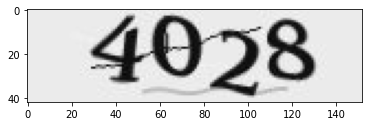

In [11]:
print(np.argmax(Y[:,10,:], axis=1))
plt.imshow(X[10].reshape(42,152), cmap=plt.cm.binary)
plt.show()

## Data spliting

In [13]:
# Split and prepair data for model fitting

xtrain, ytrain = X[:3900], Y[:, :3900]
xtest, ytest = X[3900:], Y[:, 3900:]

xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((3900, 42, 152, 1), (4, 3900, 10), (199, 42, 152, 1), (4, 199, 10))

# Define model

In [14]:
# Define convoloutional model
def create_model():
  img_shape=(42,152,1)
  num_symbols=len(symbols)
  img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
  conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
  mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
  conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
  mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
  conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
  bn = layers.BatchNormalization()(conv3)
  mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
  # Get flattened vector and make 5 branches from it. Each branch will predict one letter
  flat = layers.Flatten()(mp3)

  outs = []
  for _ in range(4):
    dens1 = layers.Dense(64, activation='relu')(flat)
    drop = layers.Dropout(0.5)(dens1)
    res = layers.Dense(num_symbols, activation='sigmoid')(drop)

    outs.append(res)

  # Create model 
  model = keras.Model(inputs=img, outputs=outs)

  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
  return model

# Model fitting

In [15]:
# Call create_model function
model = create_model()

# Fit created model
hist = model.fit(xtrain, [ytrain[0], ytrain[1], ytrain[2], ytrain[3]], batch_size=32, epochs=30,verbose=1, validation_split=0.2)

Epoch 1/30
98/98 [==============================] - 14s 30ms/step - loss: 9.3404 - dense_1_loss: 2.2987 - dense_3_loss: 2.3540 - dense_5_loss: 2.3523 - dense_7_loss: 2.3354 - dense_1_accuracy: 0.1176 - dense_3_accuracy: 0.1019 - dense_5_accuracy: 0.1061 - dense_7_accuracy: 0.1026 - val_loss: 9.1922 - val_dense_1_loss: 2.2852 - val_dense_3_loss: 2.3030 - val_dense_5_loss: 2.3021 - val_dense_7_loss: 2.3019 - val_dense_1_accuracy: 0.1449 - val_dense_3_accuracy: 0.1103 - val_dense_5_accuracy: 0.0923 - val_dense_7_accuracy: 0.1128
Epoch 2/30
98/98 [==============================] - 2s 21ms/step - loss: 8.9792 - dense_1_loss: 2.1362 - dense_3_loss: 2.2900 - dense_5_loss: 2.2946 - dense_7_loss: 2.2584 - dense_1_accuracy: 0.1657 - dense_3_accuracy: 0.1163 - dense_5_accuracy: 0.1208 - dense_7_accuracy: 0.1542 - val_loss: 9.0629 - val_dense_1_loss: 2.2047 - val_dense_3_loss: 2.2906 - val_dense_5_loss: 2.2935 - val_dense_7_loss: 2.2740 - val_dense_1_accuracy: 0.3090 - val_dense_3_accuracy: 0.1744

## Save/Load Model

In [ ]:
from keras.models import load_model

if use_pretrained == False:
  model.save('Captcha_Recog.h5')
  print("Saved model to disk")

# load model
else:
  if use_colab == True:
    model = load_model('/content/drive/MyDrive/prj/captcha_recognition/Captcha_Recog.h5')
    print('Model loaded from google drive')
  else:
    model = load_model('pretrained_model/Captcha_Recog.h5')
    print('Model loaded from your machine')

Model loaded from your machine


# Model evaluation

In [16]:
score = model.evaluate(xtest, [ytest[0], ytest[1], ytest[2], ytest[3]])
print('Test Loss:', score[:5])
print('Test accu:', score[5:])

7/7 [==============================] - 0s 24ms/step - loss: 1.7369 - dense_1_loss: 0.4172 - dense_3_loss: 0.6278 - dense_5_loss: 0.3502 - dense_7_loss: 0.3416 - dense_1_accuracy: 0.9095 - dense_3_accuracy: 0.9095 - dense_5_accuracy: 0.9246 - dense_7_accuracy: 0.9196
Test Loss: [1.7368583679199219, 0.4172380864620209, 0.6277710199356079, 0.3502224087715149, 0.34162676334381104]
Test accu: [0.909547746181488, 0.909547746181488, 0.9246231317520142, 0.9195979833602905]


## Visualize some test data

In [17]:
def predict(filePath):
  img = cv2.imread(filePath, cv2.IMREAD_GRAYSCALE)
  if img is not None:
      img = img.astype('float') / 255.0
  else:
      print("Not detected");
  res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
  ans = np.reshape(res, (num_digits, len(symbols)))
  l_ind = []
  probs = []
  for a in ans:
      l_ind.append(np.argmax(a))
      #probs.append(np.max(a))

  capt = ''
  for l in l_ind:
      capt += symbols[l]
  return capt#, sum(probs) / 5

True captcha: [4 8 6 7]


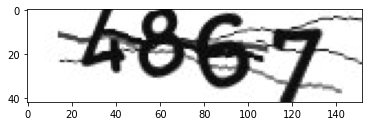

In [32]:
# Predict by xtrain, xtest

i = 7
plt.imshow(np.reshape(xtest[i], (42,152)), cmap=plt.cm.binary)
ypred = model.predict(xtest[i:i+1])
ypred = np.array(ypred)
ypred = np.reshape(ypred, (4,10))
ypred = np.argmax(ypred, axis=1)
# ypred  = [np.argmax(x) for x in ypred]
print(f'True captcha: {ypred}')

Predicted Captcha = 7496
Delay is 0.15323615074157715 seconds


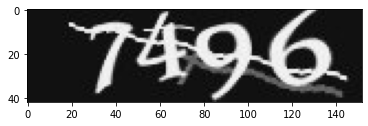

In [20]:
#Lets test an unknown captcha (by path)
#preview
%matplotlib inline 
import matplotlib.pyplot as plt

i=2500
if use_colab == True:
  test_img_path = f'/content/dataset/captcha{i}.jpg'
else:
  test_img_path = f'dataset-cat4/captcha{i}.jpg'

t = time.time()

img=cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

#Lets Predict By Model
print("Predicted Captcha =",predict(test_img_path))
print(f'Delay is {time.time()-t} seconds')

# Classification report of test data

In [28]:
from sklearn.metrics import classification_report

ypred = model.predict(xtest)
ypred = np.array(ypred)

a= ypred[0:1,:,:]
b= ypred[1:2,:,:]
c= ypred[2:3,:,:]
d= ypred[3:4,:,:]
ypred = np.concatenate((a,b,c,d), axis=1).reshape((len(xtest)*4, 10))
# ypred = np.argmax(ypred, axis=0)

for i, elem in enumerate(ypred):
  tmp = [0]*10
  argmax = np.argmax(elem)
  tmp[argmax] = 1
  ypred[i] = tmp


a= ytest[0:1,:,:]
b= ytest[1:2,:,:]
c= ytest[2:3,:,:]
d= ytest[3:4,:,:]
ytrue = np.concatenate((a,b,c,d), axis=1).reshape((len(xtest)*4, 10))
# ytrue = np.argmax(ytrue, axis=0)

for i, elem in enumerate(ytrue):
  tmp = [0]*10
  argmax = np.argmax(elem)
  tmp[argmax] = 1
  ytrue[i] = tmp

print(classification_report(ytrue, ypred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        50
           1       0.89      0.95      0.92        88
           2       0.79      0.90      0.84        80
           3       0.85      0.89      0.87        85
           4       0.94      0.87      0.91        77
           5       0.84      0.97      0.90        73
           6       0.87      0.84      0.86        96
           7       0.95      0.88      0.91        84
           8       0.93      0.77      0.84        88
           9       0.89      0.84      0.86        75

   micro avg       0.88      0.88      0.88       796
   macro avg       0.89      0.89      0.89       796
weighted avg       0.89      0.88      0.88       796
 samples avg       0.88      0.88      0.88       796

